In [1]:
import numpy as np
import nltk
from nltk.corpus import brown, wordnet as wn, gutenberg
from nltk.stem import WordNetLemmatizer
import gensim
import re
import string
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS

In [2]:
lemmatizer = WordNetLemmatizer()

def filter(token):
    """Return if token should be ignored or not.
    """
    # do not keep tokens which include digits or punctuation
    result = not re.search("[{}\d]".format(string.punctuation), token)
    return result

def replace_token(token):
    """Replace token with its lemma.
    """
    token = token.lower()
    # lemmatize token
    token = lemmatizer.lemmatize(token, "v")
    token = lemmatizer.lemmatize(token)
    return token

def get_sentences(sentences):
    """Return edited set of sentences.
    
    Args:
        sentences (List[List[str]]): list of sentences to prepare
    """
    # first, filter out tokens
    sentences = [[token for token in sent if filter(token)] for sent in sentences]
    # second, replace tokens with lowercase lemma
    sentences = [[replace_token(token) for token in sent] for sent in sentences]
    return sentences

def plot_clusters(clusters, index2vector, index2word, num_per_cluster = 10, ):
    """Plot a list of clusters.
    
    This function plots random instances of embeddings from each cluster and tries to label
    each cluster with the least common wordnet subsumer of the plotted words.
    
    Args:
        clusters (List[List[int]]): the clusters to plot
        index2vector (ndarray): array which maps indices to their embeddings
        index2word (List[str]): list which maps indices to their words
        num_per_cluster (int): number of instances to plot for each cluster
    """

    plt.figure(figsize = (25,25))

    # choose as many random colors as their are clusters
    colors = np.random.choice(np.array(list(mcolors.TABLEAU_COLORS.items()))[:, 0], len(clusters), replace = True)

    # go through all clusters
    for i, cluster in enumerate(clusters[:]):
        # select color
        color = colors[i]
        # choose random word indices to display
        random_instances = np.random.choice(cluster, min(len(cluster), num_per_cluster), replace = False)

        # iterator which only contains the selected words which are available in wordnet
        wn_words = [word for word in index2word[random_instances] if len(wn.synsets(word)) != 0]
        wn_words = iter(wn_words)
        # the lowest common subsumer of the words in a cluster
        common_hypernym = None
        for word in wn_words:
            # find initial common hypernym of the first word and a succeeding word in the cluster
            if common_hypernym is None:
                while common_hypernym is None:
                    # if there are still words left in the iterator, search for lcs 
                    try:
                        common_hypernyms = wn.synsets(word)[0].lowest_common_hypernyms(wn.synsets(next(wn_words))[0])
                        # if at least 1 lcs was found, set the first one as the current lcs and jump out of the while loop
                        if len(common_hypernyms) != 0:
                            common_hypernym = common_hypernyms[0]
                            continue
                    # if there are no more words left, jump out of the loop
                    except:
                        break
            # otherwise, find lcs of current lcs and current word
            else:
                common_hypernyms = wn.synsets(word)[0].lowest_common_hypernyms(common_hypernym)

                # if at least 1 lcs was found, set the first one as the current lcs
                if len(common_hypernyms) != 0:
                    common_hypernym = common_hypernyms[0]

        # display the randomly chosen words of the current cluster and create a legend for the cluster with the lcs as label
        for i, (x,y) in enumerate(index2vector[random_instances]):
            # set the label for the first word in the cluster
            if i == 0:
                plt.scatter(x, y, color = color, label = str(common_hypernym))
            # plot the remaining words without a label
            else:
                plt.scatter(x, y, color = color)

            # annotate every word
            plt.annotate(index2word[random_instances[i]],
                        xy = (x,y),
                        xytext=(5,2),
                        textcoords="offset points",
                        ha="right",
                        va="bottom")


    plt.legend()
    plt.savefig("embeddings.png")
    plt.show()
    
def get_clusters(kind, vectors, n_clusters = None, min_samples = None, eps = None):
    if kind == "kmeans":
        assert n_clusters != None
        clusters = KMeans(n_clusters = n_clusters).fit(vectors)
    elif kind == "dbscan":
        assert min_samples != None and eps != None
        clusters = DBSCAN(eps = eps, min_samples = min_samples).fit(vectors)
    else:
        assert min_samples != None and eps != None
        clusters = OPTICS(min_samples = min_samples, max_eps = eps).fit(vectors)
        
    # create list of arrays which contain the indices of the corresponding cluster
    clusters = [np.array([i for i, cluster in enumerate(clusters.labels_) if cluster == j]) 
                for j in range(min(clusters.labels_), max(clusters.labels_) + 1)]
    
    print("Number of found clusters: ", len(clusters))
    
    return clusters

In [68]:
# brown corpus sentences
sentences = get_sentences(brown.sents(categories = ["romance", "adventure", "science_fiction", "mystery"]))

In [3]:
# gutenberg corpus sentences
sentences = get_sentences(gutenberg.sents("austen-emma.txt"))

In [4]:
# train word2vec model on a set of sentences
word2vec = gensim.models.Word2Vec(sentences, size = 50, iter = 200, min_count = 10, window = 10, negative = 5)

Number of found clusters:  23
Explained variance:  [0.2385597  0.11066052]


C:\Users\robin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


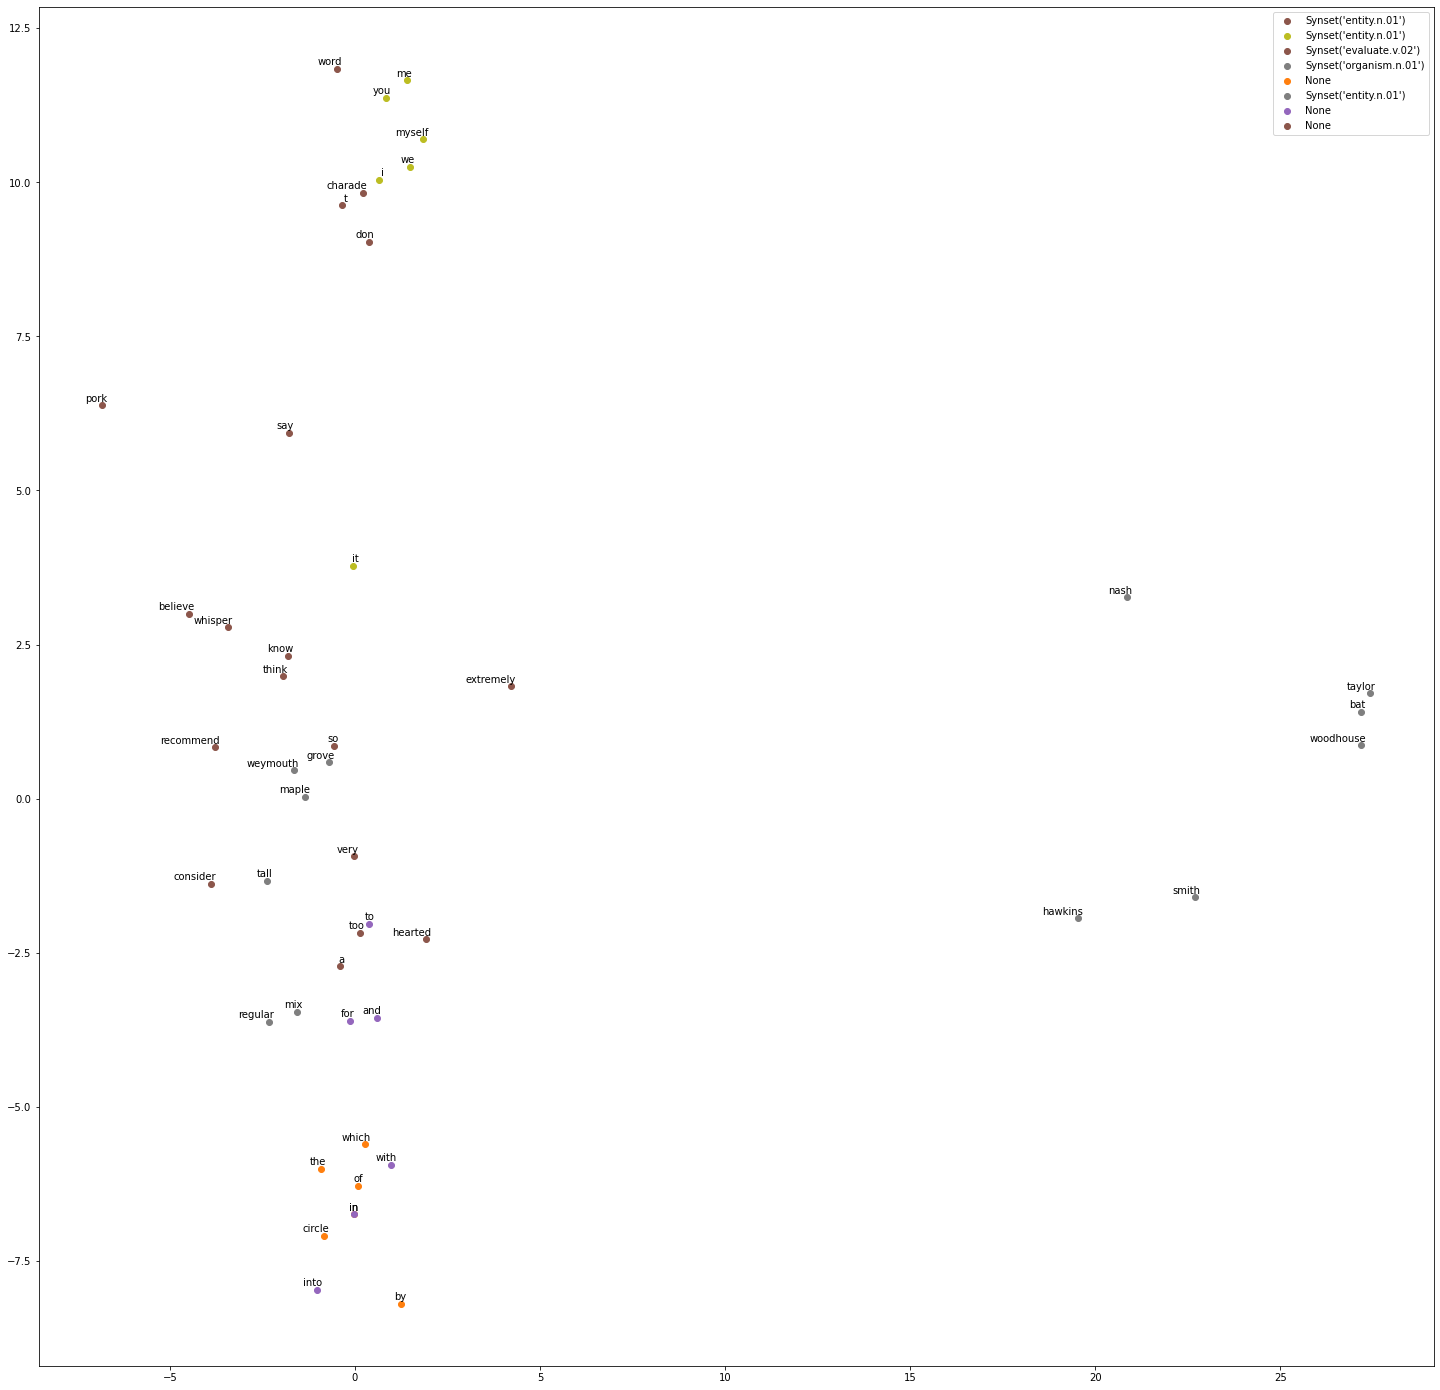

In [6]:
# obtain clusters by 
# 1) obtaining initial clusters of the embedding space with kmeans
# 2) obtaining the most frequent word of these clusters
# 3) obtaining similiarity clusters by putting every most frequent word together with its n most similar word
# 4) obtaining 2d embeddings by applying pca to the words in the sim. clusters

index2word = np.array(word2vec.wv.index2word)
word2index = {word: index for index, word in enumerate(index2word)}
index2vector = np.array(word2vec.wv.vectors)
    
# first, obtain clusters from the initital word2vec vectors
initial_clusters = get_clusters("optics", index2vector, min_samples = 2, eps = 40.0)
# get the most frequent (smallest index) word from every cluster
instance_per_cluster = [min(cluster) for cluster in np.random.choice(initial_clusters, 8, replace = False)]
# for every most frequent word of a cluster, get the 10 most similar words of that word
sim_clusters = [[index] + [word2index[word] 
                           for word, _ in word2vec.wv.most_similar(positive=[index2word[index]], topn = 5)]
               for index in instance_per_cluster]
# put all indices in one list
indices = [index for cluster in sim_clusters for index in cluster]

index2word = index2word[indices]
# map the initial indices to the indices that were selected above
old_index2new_index = {old_index: new_index for new_index, old_index in enumerate(indices)}
word2index = {word: index for index, word in enumerate(index2word)}
index2vector = index2vector[indices]

# fit a pca model on the selected indices
pca = PCA(n_components = 2)
pca.fit(index2vector)
# print explained variance ratios
print("Explained variance: ", pca.explained_variance_ratio_)
# obtain the new, 2 dimensional, word embeddings for the selected instances
index2vector = np.matmul(index2vector, np.transpose(pca.components_))

# get the initial "similarity clusters" with the new indices
clusters = [[old_index2new_index[index] for index in cluster] for cluster in sim_clusters]

# plot the clusters
plot_clusters(clusters, index2vector, index2word, 10)